# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using regression.

# Necessary Packages and Libraries

In [211]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# Regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Classification
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Pipeline
from sklearn.pipeline import Pipeline

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler as ROS

# Dimesionality reduction
from sklearn.decomposition import PCA
pca = PCA()

# Graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (15,8)
hspace = 0.5

# Pickling
import pickle
from sklearn.externals import joblib

# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns a float
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features, FI_labels):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), FI_labels) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

### Regression Results Plott

In [74]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets"""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [ ]:
# # The stat_id will be inserted into the url for each ping
# stats = [
#     {'stat_name': 'driving_distance',
#      'stat_id': '101'},
#     {'stat_name': 'driving_accuracy', 
#      'stat_id': '102'},
#     {'stat_name': 'greens_in_regulation', 
#      'stat_id': '103'},
#     {'stat_name': 'proximity', 
#      'stat_id': '331'},
#     {'stat_name': 'scrambling_rough',  
#      'stat_id': '363'},
#     {'stat_name': 'scrambling_sand',  
#      'stat_id': '362'},
#     {'stat_name': 'putting_conversion',
#      'stat_id': '115'},
#     {'stat_name': 'putting_rating',
#      'stat_id': '402'},
#     {'stat_name': 'sg_off_tee',
#      'stat_id': '02567'},
#     {'stat_name': 'sg_approach',
#      'stat_id': '02568'},
#     {'stat_name': 'sg_scrambling',  
#      'stat_id': '02569'},
#     {'stat_name': 'sg_putting',
#      'stat_id': '02564'},
#     {'stat_name': 'sg_tee_to_green',  
#      'stat_id': '02674'},
#     {'stat_name': 'sg_total',  
#      'stat_id': '02675'},
#     {'stat_name': 'scoring_avg',  
#      'stat_id': '120'},
# ]

### Seasons Considered

In [ ]:
# # Since strokes_gained stats only go back to 2004, we will consider 2004-2019
# seasons = range(2004, 2020)

### Webscrapping and Dataframe Conversion

In [ ]:
# # Call the web scrapping helper function defined above. Save the results and examine Dataframe
# data = get_PGA_Tour_data(stats, seasons)

In [ ]:
# # Convert data to Dataframe and save raw data locally
# df = pd.DataFrame(data)
# df.to_csv('csv_files/raw_golfer_data.csv')

## Data Cleaning

### Convert Features

In [7]:
# Reload raw data and examine dataframe
df = pd.read_csv('csv_files/raw_golfer_data.csv', index_col=0)
df.drop('str_diff_to_field', axis=1, inplace=True)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(48592, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,hank_kuehne,314.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,scott_hend,312.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,john_daly,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,mike_heinen,305.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,chris_smith,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert proximity to feet floats and str_diff_to_field to stroke floats
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
df['driving_accuracy'] = df['driving_accuracy']/100
df['greens_in_regulation'] = df['greens_in_regulation']/100
df['scrambling_rough'] = df['scrambling_rough']/100
df['scrambling_sand'] = df['scrambling_sand']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [9]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'driving_distance','driving_accuracy','greens_in_regulation','proximity',
    'scrambling_rough','scrambling_sand','putting_conversion','putting_rating',
    'sg_off_tee','sg_approach','sg_scrambling','sg_putting','sg_tee_to_green',
    'sg_total','scoring_avg'].mean()

# Save grouped data locally
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine data
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(3036, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Add Missing Golfers

In [10]:
# Import new csv file that contains data on missing golfers
missing = pd.read_csv('csv_files/masters_results - missing.csv')

print(missing.shape)
missing

(27, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,trevor_immelman,282.3,63.89,60.34,"36' 5""",50.85,48.480,25.45,1.633,0.057,0.282,-0.031,-1.020,0.308,0.207,71.224
1,2005,ángel_cabrera,311.2,53.30,63.33,"37' 10""",54.29,47.500,29.03,1.665,0.531,0.067,0.141,-0.136,0.739,0.603,70.669
2,2006,paul_casey,305.3,62.66,67.17,"32' 1""",45.00,53.570,26.42,1.707,0.118,1.385,-0.249,-0.641,1.254,0.613,70.837
3,2007,andres_romero,312.5,56.25,58.89,"33' 10""",76.47,62.160,26.42,1.572,1.988,-0.457,0.342,0.416,1.873,2.289,68.653
4,2007,robert_karlsson,298.9,51.02,57.54,"36' 2""",51.55,44.440,27.36,1.631,-0.130,-0.219,-0.025,-0.374,-0.022,-0.396,71.396
5,2008,tiger_woods,294.3,57.86,71.39,"34' 6""",68.18,48.390,31.89,1.592,0.513,1.991,0.461,0.850,2.966,3.815,67.646
6,2009,lee_westwood,294.9,65.31,68.85,"33' 10""",68.42,34.090,29.97,1.657,0.000,0.000,0.000,-0.600,1.007,0.947,69.706
7,2010,charl_schwartzel,300.8,62.05,59.72,"36' 0""",55.88,63.640,29.65,1.615,-0.505,0.865,0.338,0.528,0.699,1.227,70.879
8,2010,tiger_woods,295.8,57.21,64.07,"34' 11""",44.19,47.143,32.63,1.615,-0.207,0.474,-0.092,-0.036,0.174,0.139,70.318
9,2011,lee_westwood,301.8,60.08,68.95,"32' 2""",56.82,53.230,30.88,1.627,0.000,0.000,0.000,-0.161,1.774,1.613,68.962


In [11]:
# Convert the features of missing golfers
missing['proximity'] = missing['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
missing['driving_accuracy'] = missing['driving_accuracy']/100
missing['greens_in_regulation'] = missing['greens_in_regulation']/100
missing['scrambling_rough'] = missing['scrambling_rough']/100
missing['scrambling_sand'] = missing['scrambling_sand']/100
missing['putting_conversion'] = missing['putting_conversion']/100

In [12]:
concat = [df, missing]
df = pd.concat(concat)

In [13]:
df.sort_values(by=['season', 'full_name'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(3063, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Incorporate Historical Tournament Data

In [14]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('csv_files/masters_results - data.csv')
masters_results['full_name'] = masters_results['full_name'].apply(lambda x: format_golfer(x))
masters_results = masters_results.sort_values(by=['masters_year', 'full_name'])

print(masters_results.shape)
masters_results.head()

(1469, 11)


,masters_year,full_name,total_score,prior_score,masters_last5,usopen_last5,british_last5,pga_last5,made_cut,top_10,champion
32,2005,adam_scott,294,315,0,0,0,0,1,0,0
51,2005,austin_eaton_iii,315,315,0,0,0,0,0,0,0
52,2005,ben_crenshaw,315,315,0,0,0,0,0,0,0
53,2005,ben_curtis,315,315,0,0,1,0,0,0,0
19,2005,bernhard_langer,289,285,0,0,0,0,1,0,0


In [15]:
# Merge dataframes together on name
df = pd.merge(df, masters_results, how='left', on='full_name')

# Drop Nans
df.dropna(inplace=True)

# Only consider rows where golfer participated the following masters
df = df[df['masters_year']-df['season'] == 1]

# Drop Masters year and reset Index
df.drop('masters_year', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Change floats to integers
df['made_cut'] = df['made_cut'].astype(int)
df['top_10'] = df['top_10'].astype(int)
df['champion'] = df['champion'].astype(int)
df['total_score'] = df['total_score'].astype(int)
df['prior_score'] = df['prior_score'].astype(int)
df['masters_last5'] = df['masters_last5'].astype(int)
df['usopen_last5'] = df['usopen_last5'].astype(int)
df['british_last5'] = df['british_last5'].astype(int)
df['pga_last5'] = df['pga_last5'].astype(int)

# Reorder columns and examine new dataframe
cols = ['season', 'full_name', 'champion', 'top_10', 'made_cut', 'total_score', 'prior_score',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'proximity',
        'scrambling_rough', 'scrambling_sand', 'putting_conversion', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
        'sg_total', 'scoring_avg',
        'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5']

df = df[cols]

print(df.shape)
df.head()

(951, 26)


,season,full_name,champion,top_10,made_cut,total_score,prior_score,driving_distance,driving_accuracy,greens_in_regulation,...,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,masters_last5,usopen_last5,british_last5,pga_last5
0,2004,adam_scott,0,0,1,294,315,295.4,0.5765,0.6560,...,0.571,-0.147,0.824,0.603,1.427,70.096,0,0,0,0
1,2004,ben_curtis,0,0,0,315,315,282.1,0.6434,0.6335,...,0.274,0.223,-0.174,0.669,0.494,71.578,0,0,1,0
2,2004,bernhard_langer,0,0,1,289,285,282.2,0.6257,0.6525,...,0.616,0.055,-0.229,0.700,0.471,71.246,0,0,0,0
3,2004,bo_van_pelt,0,0,0,315,315,294.4,0.6515,0.6768,...,0.194,0.094,0.346,0.800,1.146,70.245,0,0,0,0
4,2004,carlos_franco,0,0,0,315,315,290.6,0.5933,0.6846,...,0.413,0.236,-0.134,0.779,0.645,70.768,0,0,0,0


# Feature Engineering

## Birdie or Better Distance
Generate a circle where the radius equals a golfer's maximum distance from the hole in which the golfer will make a birdie or better from

In [16]:
df['otg_area'] = df['proximity']**2 * np.pi
df['bob_area'] = df['otg_area']*df['putting_conversion']
df['bob_distance'] = np.sqrt(df['bob_area']/np.pi)
df.drop(['proximity', 'putting_conversion',
         'otg_area', 'bob_area'], axis=1, inplace=True)

## Field Average Score
Create a column that is the average score of the field that year for each golfer

In [17]:
# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut', 'total_score', 'prior_score',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg', 
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total',
        'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(951, 25)


,full_name,season,champion,top_10,made_cut,total_score,prior_score,driving_distance,driving_accuracy,greens_in_regulation,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
0,aaron_baddeley,2006,0,0,1,307,315,288.3,0.6073,0.5826,...,-0.106,-0.607,0.196,0.595,-0.517,0.078,0,0,0,0
1,aaron_baddeley,2007,0,0,0,315,307,291.9,0.6000,0.6035,...,0.152,-0.252,0.535,0.629,0.435,1.064,0,0,0,0
2,aaron_baddeley,2008,0,0,1,284,315,290.3,0.5945,0.6202,...,0.096,-0.192,0.218,0.762,0.123,0.885,0,0,0,0
3,aaron_baddeley,2010,0,0,1,293,315,298.9,0.5665,0.6460,...,0.112,-0.797,0.391,0.502,-0.294,0.208,0,0,0,0
4,aaron_baddeley,2011,0,0,1,293,293,296.2,0.5567,0.6548,...,0.190,0.196,0.438,0.324,0.824,1.148,0,0,0,0


In [18]:
# Get each year's Masters Tournament average score for the field
hist_scores = pd.DataFrame(df.groupby('season')['prior_score'].mean())
hist_scores.reset_index(drop=False, inplace=True)
hist_scores['prior_afs'] = hist_scores['prior_score'].astype(int)
hist_scores.drop('prior_score', axis=1, inplace=True)

# Merge with our dataframe
df = pd.merge(df, hist_scores, how='inner', on='season')

In [19]:
# Reorder and examine dataframe
cols = ['full_name', 'season', 'champion', 'top_10', 'made_cut', 'total_score', 'prior_score', 'prior_afs',
        'driving_distance', 'driving_accuracy',
        'greens_in_regulation', 'bob_distance', 
        'scrambling_rough', 'scrambling_sand',
        'putting_rating', 'scoring_avg',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total',
        'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5']

df = df[cols]

print(df.shape)
df.head()

(951, 26)


,full_name,season,champion,top_10,made_cut,total_score,prior_score,prior_afs,driving_distance,driving_accuracy,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
0,aaron_baddeley,2006,0,0,1,307,315,302,288.3,0.6073,...,-0.106,-0.607,0.196,0.595,-0.517,0.078,0,0,0,0
1,adam_scott,2006,0,0,1,300,292,302,301.1,0.6200,...,0.955,1.115,0.160,-0.130,2.230,2.101,0,0,0,0
2,arron_oberholser,2006,0,0,1,310,288,302,285.0,0.6253,...,0.095,0.589,0.243,0.167,0.927,1.095,0,0,0,0
3,bart_bryant,2006,0,0,0,315,315,302,282.2,0.7276,...,0.299,0.379,-0.145,-0.138,0.533,0.395,0,0,0,0
4,ben_crane,2006,0,0,0,315,315,302,285.8,0.6351,...,-0.233,-0.408,0.272,0.849,-0.369,0.480,0,0,0,0


## Strokes Gained On Field
Create a new column that calculates how much better (or worse) the golfer did than the field average that year

In [20]:
# Create column
df['sg_on_field'] = df['prior_afs']-df['prior_score']

# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'prior_afs', 'sg_on_field',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total',
        'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

## Experience and Rolling Averages

In [21]:
# Generate a list of unique golfers and nan values to poulate 2019
golfers = df['full_name'].unique().tolist()

# Create a list of dictionaries to house each golfers prior score at the Masters for every year
names_and_scores = []
for golfer in golfers:
    name_and_scores = {}
    name_and_scores['golfer'] = golfer
    prior_scores = []
    strokes_gained_on_field = []
    for i in range(df.shape[0]):
        if golfer == df['full_name'].iloc[i]:
            prior_scores.append(df['prior_score'].iloc[i])
            strokes_gained_on_field.append(df['sg_on_field'].iloc[i])
        else:
            continue
    name_and_scores['prior_scores'] = prior_scores
    name_and_scores['strokes_gained_on_field'] = strokes_gained_on_field
    names_and_scores.append(name_and_scores)

# Loop through list of dictionaries and create a rolling avg of prior scores list for each golfer
for golfer in names_and_scores:
    prior_scores_rolling_avg = []
    strokes_gained_rolling_avg = []
    experiences = []
    i = 1
    while i <= len(golfer['prior_scores']):
        prior_score_rolling_avg = np.mean(golfer['prior_scores'][:i])
        prior_scores_rolling_avg.append(prior_score_rolling_avg)
        sg_rolling_avg = np.mean(golfer['strokes_gained_on_field'][:i])
        strokes_gained_rolling_avg.append(sg_rolling_avg)
        experience = len(prior_scores_rolling_avg)
        experiences.append(experience)
        i += 1
    golfer['ps_roll_avg'] = prior_scores_rolling_avg
    golfer['sg_roll_avg'] = strokes_gained_rolling_avg
    golfer['experience'] = experiences

# Join all of the sepearate lists together
prior_scores_rolling_avg = []
strokes_gained_rolling_avg = []
experiences = []
for golfer in names_and_scores:
    prior_scores_rolling_avg.extend(golfer['ps_roll_avg'])
    strokes_gained_rolling_avg.extend(golfer['sg_roll_avg'])
    experiences.extend(golfer['experience'])

# Add to our dataframe
df['experience'] = experiences
df['ps_roll_avg'] = prior_scores_rolling_avg
df['sg_roll_avg'] = strokes_gained_rolling_avg

# Reorder and examine dataframe
cols = ['full_name', 'season', 'experience', 'champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field',
        'sg_roll_avg', 'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total',
        'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5']

df = df[cols]

print(df.shape)
df.head()

(951, 30)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,-0.106,-0.607,0.196,0.595,-0.517,0.078,0,0,0,0
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.152,-0.252,0.535,0.629,0.435,1.064,0,0,0,0
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.096,-0.192,0.218,0.762,0.123,0.885,0,0,0,0
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.112,-0.797,0.391,0.502,-0.294,0.208,0,0,0,0
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.190,0.196,0.438,0.324,0.824,1.148,0,0,0,0


# Holdout Set

In [22]:
# Create holdout set of 2019 data. Holdout set will be used for predicting 2020 Masters results
holdout = df[df['season'] == 2019]
df = df[df['season'] != 2019]

# Examine holdout and dataframe
print(f"Holdout Set: {holdout.shape}")
print(f"Validation Set: {df.shape}")

# Overwrite grouped data and save both the holdout set and grouped dataframe locally
holdout.to_csv('csv_files/holdout_data.csv')
df.to_csv('csv_files/no_2019_golfer_data.csv')

Holdout Set: (56, 30)
Validation Set: (895, 30)


# Exploratory Data Analysis

## General Information

In [23]:
df = pd.read_csv('csv_files/no_2019_golfer_data.csv', index_col=0)

print(df.shape)
df.head(10)

(895, 30)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,-0.106,-0.607,0.196,0.595,-0.517,0.078,0,0,0,0
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.152,-0.252,0.535,0.629,0.435,1.064,0,0,0,0
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.096,-0.192,0.218,0.762,0.123,0.885,0,0,0,0
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.112,-0.797,0.391,0.502,-0.294,0.208,0,0,0,0
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.190,0.196,0.438,0.324,0.824,1.148,0,0,0,0
5,aaron_wise,2018,1,0,0,1,281,315,315.000000,294,...,0.410,0.012,0.042,0.238,0.464,0.703,0,0,0,0
7,adam_hadwin,2016,1,0,0,1,294,315,315.000000,304,...,0.223,-0.055,-0.081,0.530,-0.011,0.519,0,0,0,0
8,adam_hadwin,2017,2,0,0,1,287,294,304.500000,299,...,0.003,0.183,-0.044,0.409,0.143,0.551,0,0,0,0
9,adam_scott,2004,1,0,0,1,294,315,315.000000,303,...,0.180,0.571,-0.147,0.824,0.603,1.427,0,0,0,0
10,adam_scott,2005,2,0,0,1,292,294,304.500000,303,...,0.441,0.566,0.024,0.016,1.030,1.047,0,0,0,0


In [24]:
top10 = df[df['top_10'] == 1]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 950
Data columns (total 30 columns):
full_name               895 non-null object
season                  895 non-null int64
experience              895 non-null int64
champion                895 non-null int64
top_10                  895 non-null int64
made_cut                895 non-null int64
total_score             895 non-null int64
prior_score             895 non-null int64
ps_roll_avg             895 non-null float64
prior_afs               895 non-null int64
sg_on_field             895 non-null int64
sg_roll_avg             895 non-null float64
driving_distance        895 non-null float64
driving_accuracy        895 non-null float64
greens_in_regulation    895 non-null float64
bob_distance            895 non-null float64
scrambling_rough        895 non-null float64
scrambling_sand         895 non-null float64
putting_rating          895 non-null float64
scoring_avg             895 non-null float64
sg_off_tee    

In [26]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 15 to 946
Data columns (total 30 columns):
full_name               159 non-null object
season                  159 non-null int64
experience              159 non-null int64
champion                159 non-null int64
top_10                  159 non-null int64
made_cut                159 non-null int64
total_score             159 non-null int64
prior_score             159 non-null int64
ps_roll_avg             159 non-null float64
prior_afs               159 non-null int64
sg_on_field             159 non-null int64
sg_roll_avg             159 non-null float64
driving_distance        159 non-null float64
driving_accuracy        159 non-null float64
greens_in_regulation    159 non-null float64
bob_distance            159 non-null float64
scrambling_rough        159 non-null float64
scrambling_sand         159 non-null float64
putting_rating          159 non-null float64
scoring_avg             159 non-null float64
sg_off_tee   

In [27]:
df.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,...,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.00000,895.000000,895.000000,895.000000
mean,3.778771,300.803352,303.081168,300.413408,-0.389944,-1.935856,292.145251,0.620209,0.659189,19.249806,...,0.206085,0.291841,0.094941,0.109992,0.592802,0.706368,0.07933,0.067039,0.072626,0.074860
std,2.932918,13.989345,9.739524,3.310048,13.607181,9.934741,8.971336,0.049987,0.027971,1.128083,...,0.356128,0.372284,0.222722,0.343016,0.604835,0.642931,0.31617,0.267513,0.295907,0.295349
min,1.000000,270.000000,279.000000,294.000000,-21.000000,-21.000000,268.500000,0.483100,0.543300,15.612389,...,-2.158000,-2.155000,-0.930000,-1.216000,-3.923000,-2.385000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,288.000000,295.464286,299.000000,-13.000000,-12.000000,285.700000,0.585300,0.642200,18.500484,...,-0.005500,0.079500,-0.046500,-0.119000,0.269000,0.334000,0.00000,0.000000,0.000000,0.000000
50%,3.000000,298.000000,302.250000,300.000000,3.000000,-1.125000,292.000000,0.619700,0.660800,19.227367,...,0.213000,0.300000,0.095000,0.116000,0.596000,0.711000,0.00000,0.000000,0.000000,0.000000
75%,5.000000,315.000000,315.000000,303.000000,12.000000,5.666667,298.100000,0.649800,0.678350,19.954849,...,0.431000,0.512500,0.248000,0.338500,0.929500,1.069000,0.00000,0.000000,0.000000,0.000000
max,15.000000,315.000000,315.000000,305.000000,28.000000,24.000000,319.700000,0.784300,0.741500,22.704801,...,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,3.00000,2.000000,2.000000,2.000000


In [28]:
top10.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,...,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,4.075472,297.094340,299.852486,300.132075,3.037736,1.139679,295.696855,0.608222,0.665431,19.436097,...,0.317811,0.441371,0.145327,0.123591,0.917006,1.049774,0.176101,0.182390,0.150943,0.188679
std,2.882833,14.373319,10.477060,3.401625,13.899680,10.786490,9.241681,0.043915,0.030560,1.144267,...,0.382935,0.426832,0.210813,0.392486,0.625655,0.715918,0.484371,0.447996,0.452681,0.505286
min,1.000000,270.000000,279.000000,294.000000,-21.000000,-21.000000,277.000000,0.510200,0.550000,16.490958,...,-0.506000,-1.311000,-0.437000,-1.216000,-0.715000,-0.968000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,286.000000,292.166667,299.000000,-12.000000,-9.333333,289.350000,0.575250,0.649750,18.612870,...,0.054500,0.224000,-0.008000,-0.141000,0.497500,0.639500,0.000000,0.000000,0.000000,0.000000
50%,3.000000,291.000000,298.000000,300.000000,8.000000,3.000000,295.400000,0.605000,0.668900,19.479940,...,0.304000,0.474000,0.170000,0.128000,0.882000,0.985000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,315.000000,309.225000,303.000000,14.500000,8.000000,301.050000,0.641050,0.687100,20.277329,...,0.540500,0.617000,0.273000,0.368500,1.269500,1.385500,0.000000,0.000000,0.000000,0.000000
max,13.000000,315.000000,315.000000,305.000000,27.000000,24.000000,317.700000,0.719000,0.741500,22.704801,...,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,3.000000,2.000000,2.000000,2.000000


## Target Variable Summaries

### Cut Line

In [29]:
# Define the cutlines
cut_lines = pd.read_csv('csv_files/masters_results - cutline.csv')

print(cut_lines.shape)
cut_lines.head()

(15, 3)


,season,total_score,relative_to_par
0,2005,149,5
1,2006,149,5
2,2007,153,9
3,2008,148,4
4,2009,146,2


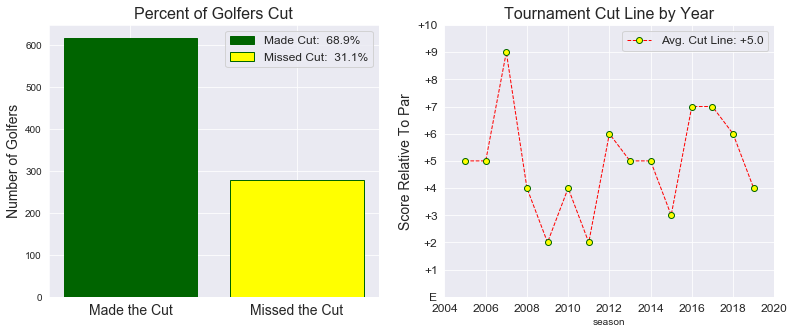

In [30]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Percent of Golfers Cut", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Made the Cut', 'Missed the Cut'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper right', fontsize='large');

# Cutline overtime
avg_cutline = round(cut_lines['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Cut Line: +{avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.set_yticks(range(0, 11));
ax2.set_yticklabels(
    ('E', '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8', '+9', '+10')
);
ax2.set_xlim(2004, 2020);
ax2.legend(loc='upper right', fontsize='large');

### Top 10

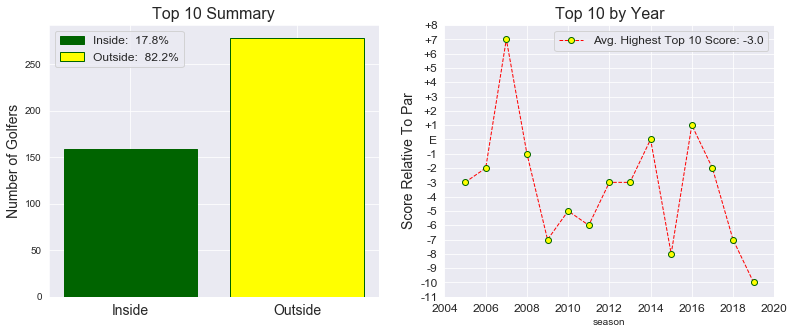

In [31]:
target_variable = 'top_10'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Inside Top 10
height = df.groupby(target_variable).season.count().tolist()
outside_top10 = height[0]
inside_top10 = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=inside_top10,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Inside: {inside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Outside: {outside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.set_title("Top 10 Summary", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Inside', 'Outside'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper left', fontsize='large');

# Top 10 overtime
top_10 = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
top_10.reset_index(drop=False, inplace=True)
top_10['season'] = top_10['season']+1
top_10['relative_to_par'] = top_10['total_score']-(72*4)
avg_top10 = round(top_10['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

top_10.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Highest Top 10 Score: {avg_top10}'
);
ax2.set_title("Top 10 by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
ax2.set_yticks(range(-11, 9));
ax2.set_yticklabels(
    ('-11', '-10', '-9', '-8',
     '-7', '-6', '-5', '-4',
     '-3', '-2', '-1', 'E',
     '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8')
);
ax2.set_xlim(2004, 2020);

In [32]:
top10 = df[df['top_10'] == 1]
top10 = pd.DataFrame(top10['full_name'].value_counts())
top10.iloc[:5]

,full_name
tiger_woods,9
phil_mickelson,7
lee_westwood,5
justin_rose,5
rory_mcilroy,5


### Past Champions and Worst Performers

In [33]:
# Create a new dataframe that grabs golfers, their total experience, and number/pct of times they made the cut
experience = pd.DataFrame(df.groupby('full_name').experience.max())
experience.reset_index(drop=False, inplace=True)

cut_summary = pd.DataFrame(df.groupby('full_name').made_cut.sum())
cut_summary.reset_index(drop=False, inplace=True)

cut_summary = pd.merge(experience, cut_summary, how='outer', on='full_name')
cut_summary = cut_summary[['full_name', 'experience', 'made_cut']]
cut_summary['cuts_missed'] = cut_summary['experience'] - cut_summary['made_cut']
cut_summary['cuts_missed_pct'] = cut_summary['cuts_missed']/cut_summary['experience']*100
cut_summary = cut_summary[cut_summary['experience'] >= 4]

# Grab golfers that have missed more than 50% of cuts
augusta_hates = cut_summary[cut_summary['cuts_missed_pct'] >= 50]
raw_golfers = augusta_hates['full_name'].tolist()
golfers = [golfer.replace('_', ' ').title() for golfer in raw_golfers]
golfers = [golfer.replace('Iii', 'III') if golfer.endswith('Iii')
           else golfer for golfer in golfers]
augusta_hates['Golfers'] = golfers
augusta_hates.set_index('Golfers', inplace=True)
augusta_hates.sort_values(by='cuts_missed_pct', ascending=False, inplace=True)
augusta_hates

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,full_name,experience,made_cut,cuts_missed,cuts_missed_pct
Golfers,,,,,
Shaun Micheel,shaun_micheel,4,0,4,100.000000
Ben Curtis,ben_curtis,7,2,5,71.428571
Ben Crane,ben_crane,6,2,4,66.666667
Gary Woodland,gary_woodland,6,2,4,66.666667
Rory Sabbatini,rory_sabbatini,8,3,5,62.500000
Camilo Villegas,camilo_villegas,6,3,3,50.000000
Charles Howell III,charles_howell_iii,6,3,3,50.000000
Graeme Mcdowell,graeme_mcdowell,4,2,2,50.000000
John Senden,john_senden,6,3,3,50.000000


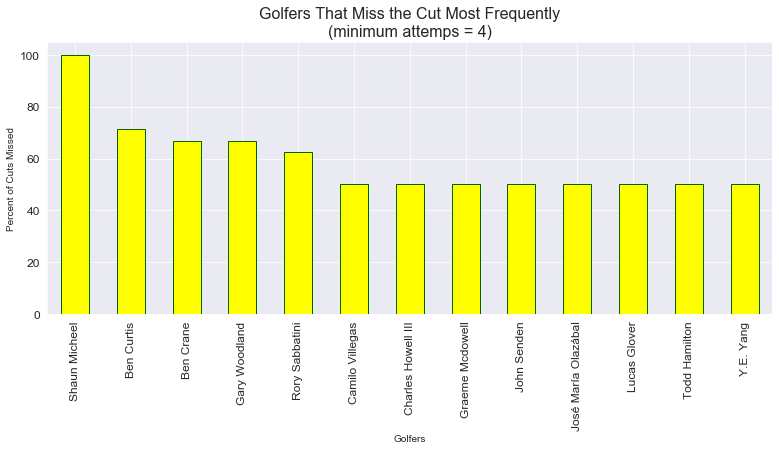

In [34]:
fig = plt.figure(figsize=(13,5));
ax = fig.add_subplot(111);
augusta_hates['cuts_missed_pct'].plot.bar(
    ax=ax,
    ec='darkgreen',
    fc='yellow',
    fontsize=12
);
ax.set_title(
    'Golfers That Miss the Cut Most Frequently\n(minimum attemps = 4)', 
    {'fontsize' : 16}
);
ax.set_ylabel('Percent of Cuts Missed');

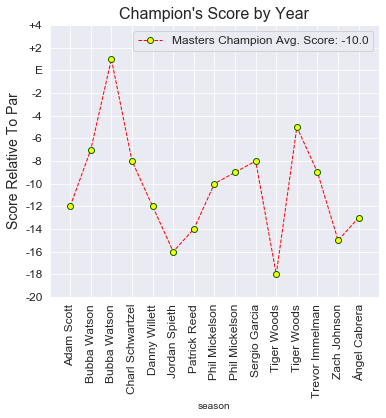

In [35]:
target_variable = 'champion'
title = 'Masters Champion'
fig = plt.figure(figsize=(13,5));

#Champion's score overtime
champion = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
champion.reset_index(drop=False, inplace=True)
champion['season'] = champion['season']+1
champion['relative_to_par'] = champion['total_score']-(72*4)
avg_champion = round(champion['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

champion.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Masters Champion Avg. Score: {avg_champion}'
);
ax2.set_title("Champion's Score by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
raw_champions = df[df['champion'] == 1].full_name.tolist()
champions = [champion.replace('_', ' ').title() for champion in raw_champions]
ax2.set_xticks(range(2005, 2020));
ax2.set_xticklabels(champions, rotation=90);
ax2.set_yticks(range(-20, 6, 2));
ax2.set_yticklabels(
    ('-20', '-18', '-16', '-14',
     '-12', '-10', '-8', '-6',
     '-4', '-2', 'E', '+2', '+4')
);
ax2.set_xlim(2004, 2020);

## Feature Exploration

### Strokes Gained Over Field

In [36]:
dataset = df[['season', 'full_name', 'experience', 'sg_roll_avg']]

exp1 = dataset[(dataset['experience'] < 6)].sg_roll_avg.mean()
exp2 = dataset[(dataset['experience'] > 5)&(dataset['experience'] < 11)].sg_roll_avg.mean()
exp3 = dataset[(dataset['experience'] > 11)].sg_roll_avg.mean()

print(exp1)
print(exp2)
print(exp3)

-3.97251720747296
4.147689452124936
6.250530171582804


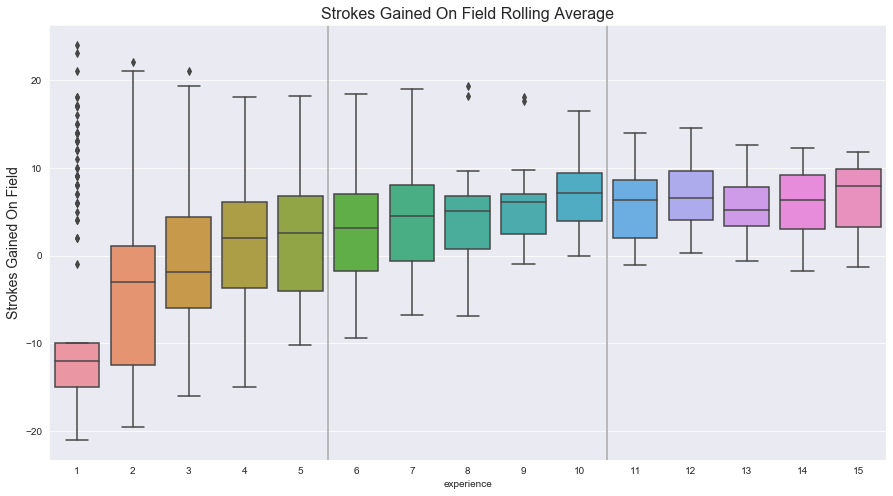

In [37]:
# Strokes Gained on field by experience
fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);


sns.boxplot(
    x=dataset['experience'],
    y=dataset['sg_roll_avg']
);
ax.axvline(4.5, color='darkgray');
ax.axvline(9.5, color='darkgray');
ax.set_ylabel('Strokes Gained On Field', fontsize=14);
ax.set_title('Strokes Gained On Field Rolling Average', fontsize=16);

### Feature Correlations

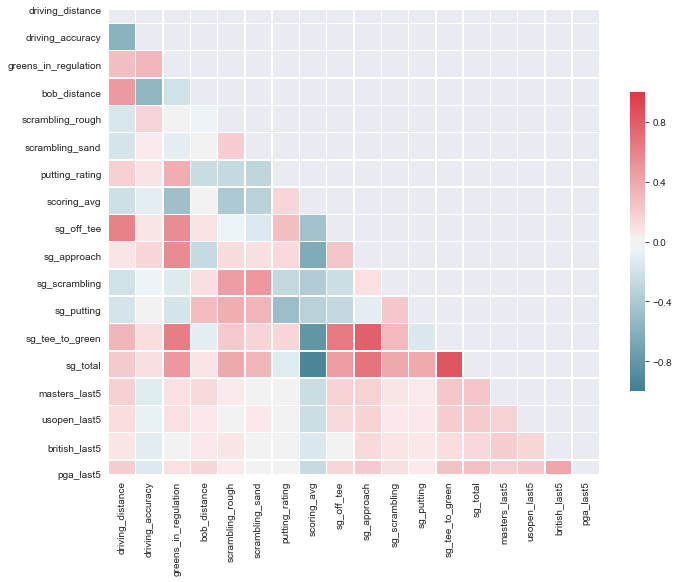

In [159]:
df_corr = df[x_cols]

fig = plt.figure(figsize=(11,11))

# Create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = fig.add_subplot(111)
sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax1);

### Test For Linearity

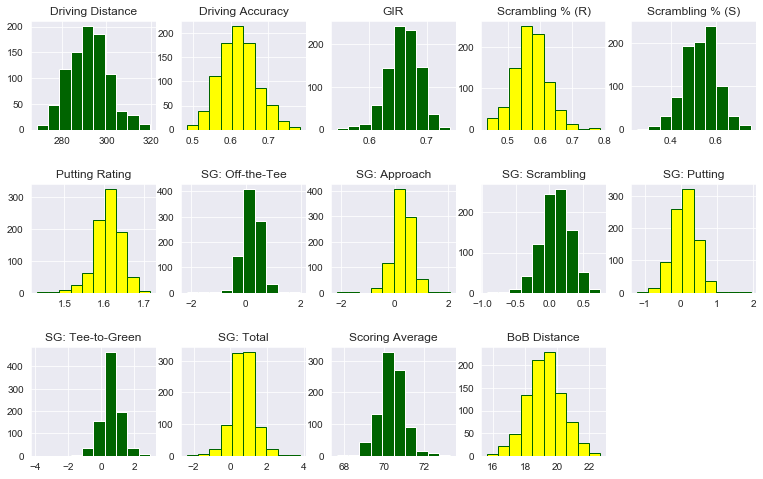

In [38]:
fig = plt.figure(figsize=(13, 8))
fig.subplots_adjust(hspace=hspace);

ax11 = fig.add_subplot(3,5,1);
ax11.hist(df['driving_distance'], fc = 'darkgreen');
ax11.set_title('Driving Distance');

ax12 = fig.add_subplot(3,5,2);
ax12.hist(df['driving_accuracy'], fc='yellow', ec='darkgreen');
ax12.set_title('Driving Accuracy');

ax13 = fig.add_subplot(3,5,3);
ax13.hist(df['greens_in_regulation'], fc = 'darkgreen');
ax13.set_title('GIR');

ax14 = fig.add_subplot(3,5,4);
ax14.hist(df['scrambling_rough'], fc='yellow', ec='darkgreen');
ax14.set_title('Scrambling % (R)');

ax21 = fig.add_subplot(3,5,5);
ax21.hist(df['scrambling_sand'], fc = 'darkgreen');
ax21.set_title('Scrambling % (S)');

ax22 = fig.add_subplot(3,5,6);
ax22.hist(df['putting_rating'], fc='yellow', ec='darkgreen');
ax22.set_title('Putting Rating');

ax23 = fig.add_subplot(3,5,7);
ax23.hist(df['sg_off_tee'], fc = 'darkgreen');
ax23.set_title('SG: Off-the-Tee');

ax24 = fig.add_subplot(3,5,8);
ax24.hist(df['sg_approach'], fc='yellow', ec='darkgreen');
ax24.set_title('SG: Approach');

ax31 = fig.add_subplot(3,5,9);
ax31.hist(df['sg_scrambling'], fc = 'darkgreen');
ax31.set_title('SG: Scrambling');

ax32 = fig.add_subplot(3,5,10);
ax32.hist(df['sg_putting'], fc='yellow', ec='darkgreen');
ax32.set_title('SG: Putting');

ax33 = fig.add_subplot(3,5,11);
ax33.hist(df['sg_tee_to_green'], fc = 'darkgreen');
ax33.set_title('SG: Tee-to-Green');

ax34 = fig.add_subplot(3,5,12);
ax34.hist(df['sg_total'], fc='yellow', ec='darkgreen');
ax34.set_title('SG: Total');

ax41 = fig.add_subplot(3,5,13);
ax41.hist(df['scoring_avg'], fc = 'darkgreen');
ax41.set_title('Scoring Average');

ax42 = fig.add_subplot(3,5,14);
ax42.hist(df['bob_distance'], fc='yellow', ec='darkgreen');
ax42.set_title('BoB Distance');

## Drop EDA Only Features

In [39]:
# Define drop list
drop = ['experience', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field', 'sg_roll_avg']
df = df.drop(drop, axis=1)

# Examine new dataframe
print(df.shape)
df.head()

(895, 24)


,full_name,season,champion,top_10,made_cut,total_score,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,...,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
0,aaron_baddeley,2006,0,0,1,307,288.3,0.6073,0.5826,21.326667,...,-0.106,-0.607,0.196,0.595,-0.517,0.078,0,0,0,0
1,aaron_baddeley,2007,0,0,0,315,291.9,0.6000,0.6035,21.005830,...,0.152,-0.252,0.535,0.629,0.435,1.064,0,0,0,0
2,aaron_baddeley,2008,0,0,1,284,290.3,0.5945,0.6202,21.109307,...,0.096,-0.192,0.218,0.762,0.123,0.885,0,0,0,0
3,aaron_baddeley,2010,0,0,1,293,298.9,0.5665,0.6460,21.237521,...,0.112,-0.797,0.391,0.502,-0.294,0.208,0,0,0,0
4,aaron_baddeley,2011,0,0,1,293,296.2,0.5567,0.6548,21.490982,...,0.190,0.196,0.438,0.324,0.824,1.148,0,0,0,0


# Model Training and Predictions

## Define Key Variables

In [40]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']

FI_labels = df.drop(['full_name', 'season', 'champion',
                     'top_10', 'made_cut', 'total_score'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'f1'

## Train, Test, and Split

In [41]:
X = df.drop(['full_name', 'season', 'champion',        
             'top_10', 'made_cut', 'total_score'], axis=1)

y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [42]:
print('Class Summary:')
print('--'*20)
y_train.value_counts(normalize=True)

Class Summary:
----------------------------------------


1    0.5
0    0.5
Name: made_cut, dtype: float64

## Making the Cut

### Base Model

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.4s finished


------------------------------------------------------
Dummy Classifier Model Best Params:
------------------------------------------------------
 strategy : uniform
------------------------------------------------------
Dummy Classifier Model F1 Scores:
------------------------------------------------------
 train:  48.52%
 test:  62.04%
------------------------------------------------------
Dummy Classifier Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.35      0.54      0.42        56
    made_cut       0.72      0.54      0.62       123

    accuracy                           0.54       179
   macro avg       0.53      0.54      0.52       179
weighted avg       0.60      0.54      0.56       179

------------------------------------------------------


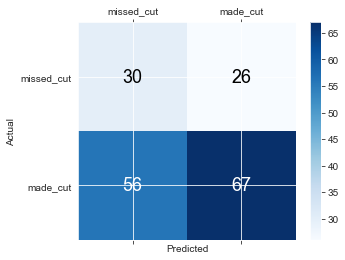

['models/noSG/base_model.pkl']

In [43]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {'strategy' : ['uniform','stratified']}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.4s finished


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
 classifier__C : 2
 classifier__penalty : l1
 classifier__solver : liblinear
 pca__n_components : 3
------------------------------------------------------
Logistic Regression Model F1 Scores:
------------------------------------------------------
 train:  62.08%
 test:  71.93%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.45      0.59      0.51        56
    made_cut       0.78      0.67      0.72       123

    accuracy                           0.64       179
   macro avg       0.61      0.63      0.61       179
weighted avg       0.68      0.64      0.65       179

------------------------------------------------------


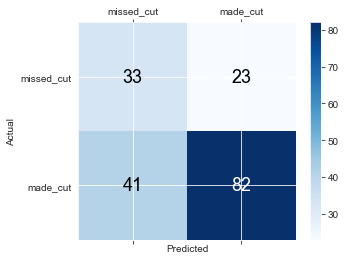

['models/noSG/log_model.pkl']

In [53]:
# Instantiate classifier and pipeline
model_name = 'Logistic Regression Model'
classifier = LogisticRegression(max_iter=1000, random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[2, 3, 4],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__C' : [1, 2,3],
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

### Decision Tree

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    5.1s finished


------------------------------------------------------
Decision Tree Model Best Params:
------------------------------------------------------
 classifier__criterion : entropy
 classifier__max_depth : 10
 classifier__min_samples_leaf : 5
 classifier__min_samples_split : 2
 pca__n_components : 3
------------------------------------------------------
Decision Tree Model F1 Scores:
------------------------------------------------------
 train:  77.28%
 test:  65.77%
------------------------------------------------------
Decision Tree Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.38      0.54      0.44        56
    made_cut       0.74      0.59      0.66       123

    accuracy                           0.58       179
   macro avg       0.56      0.56      0.55       179
weighted avg       0.62      0.58      0.59       179

-----------------------------------------------------

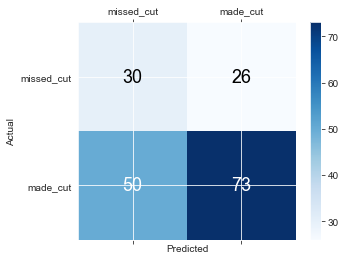

['models/noSG/dt_model.pkl']

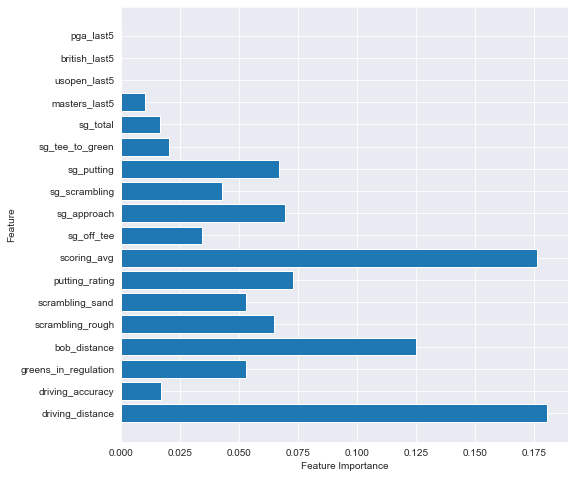

In [56]:
# Instantiate classifier and define model
model_name = 'Decision Tree Model'
classifier = DecisionTreeClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[2, 3, 4],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [2, 5, 10],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 5, 10, 20]
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['classifier__criterion'],
    max_depth = best_params['classifier__max_depth'],
    min_samples_split = best_params['classifier__min_samples_split'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.4min finished


------------------------------------------------------
Random Forest Model Best Params:
------------------------------------------------------
 classifier__criterion : entropy
 classifier__max_depth : 8
 classifier__max_features : auto
 classifier__min_samples_leaf : 10
 classifier__min_samples_split : 10
 classifier__n_estimators : 50
 pca__n_components : 15
------------------------------------------------------
Random Forest Model F1 Scores:
------------------------------------------------------
 train:  84.29%
 test:  71.43%
------------------------------------------------------
Random Forest Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.41      0.46      0.43        56
    made_cut       0.74      0.69      0.71       123

    accuracy                           0.62       179
   macro avg       0.57      0.58      0.57       179
weighted avg       0.63      0.62      0.6

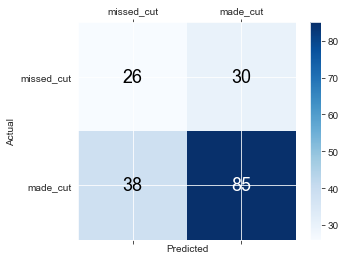

['models/noSG/rf_model.pkl']

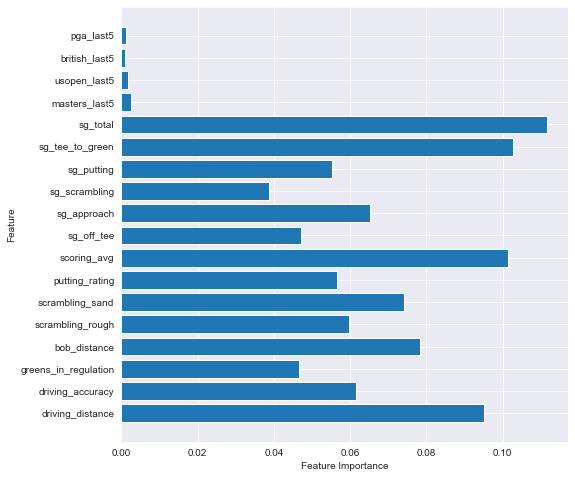

In [59]:
# Instantiate classifier and define model
model_name = 'Random Forest Model'
classifier = RandomForestClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[5, 10, 15],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__n_estimators' : [50, 100],
    'classifier__max_features' : ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [2, 5, 8],
    'classifier__min_samples_split' : [10, 20],
    'classifier__min_samples_leaf' : [10, 20]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['classifier__criterion'],
    n_estimators = best_params['classifier__n_estimators'],
    max_features = best_params['classifier__max_features'],
    max_depth = best_params['classifier__max_depth'],
    min_samples_split = best_params['classifier__min_samples_split'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, rf_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    8.1s finished


------------------------------------------------------
AdaBoost Model Best Params:
------------------------------------------------------
 classifier__learning_rate : 0.5
 classifier__n_estimators : 50
 pca__n_components : 10
------------------------------------------------------
AdaBoost Model F1 Scores:
------------------------------------------------------
 train:  72.30%
 test:  69.33%
------------------------------------------------------
AdaBoost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.42      0.57      0.48        56
    made_cut       0.76      0.63      0.69       123

    accuracy                           0.61       179
   macro avg       0.59      0.60      0.59       179
weighted avg       0.66      0.61      0.63       179

------------------------------------------------------


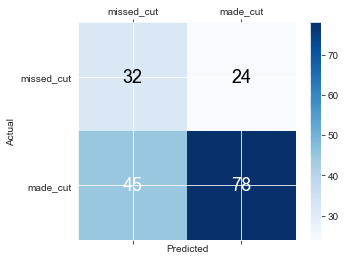

['models/noSG/ab_model.pkl']

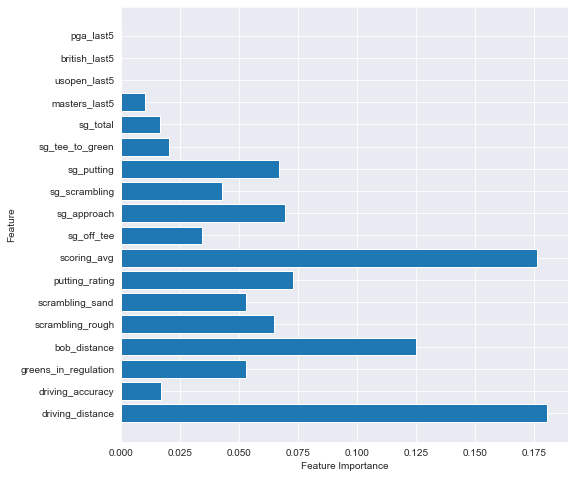

In [60]:
# Instantiate classifier and define model
model_name = 'AdaBoost Model'
classifier = AdaBoostClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [5, 10, 15],
    'classifier__n_estimators' : [50, 100],
    'classifier__learning_rate' : [0.01, 0.1, 0.2, 0.5],
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['classifier__n_estimators'],
    learning_rate = best_params['classifier__learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished


------------------------------------------------------
Gradient Boost Model Best Params:
------------------------------------------------------
 classifier__learning_rate : 0.15
 classifier__n_estimators : 25
 pca__n_components : 5
------------------------------------------------------
Gradient Boost Model F1 Scores:
------------------------------------------------------
 train:  77.83%
 test:  75.21%
------------------------------------------------------
Gradient Boost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.49      0.59      0.53        56
    made_cut       0.79      0.72      0.75       123

    accuracy                           0.68       179
   macro avg       0.64      0.65      0.64       179
weighted avg       0.70      0.68      0.68       179

------------------------------------------------------


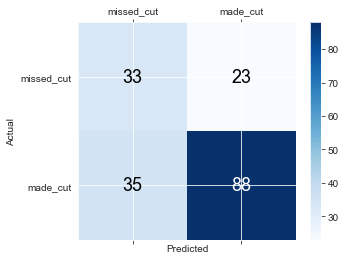

['models/noSG/gb_model.pkl']

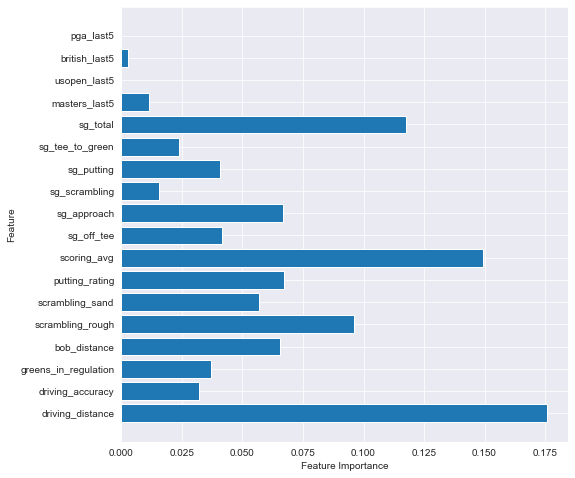

In [73]:
# Instantiate classifier and define model
model_name = 'Gradient Boost Model'
classifier = GradientBoostingClassifier(random_state=SEED)
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [5],
    'classifier__n_estimators' : [10, 25],
    'classifier__learning_rate' : [0.1, 0.15],
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['classifier__n_estimators'],
    learning_rate = best_params['classifier__learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, gb_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Results Summary

In [82]:
classifiers = [dummy_clf, log_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'decTree', 'randomF', 'adaB', 'gradB']
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    result['recall'] = round(metrics.recall_score(y_test, y_pred)*100,2)
    result['f1'] = round(metrics.f1_score(y_test, y_pred)*100,2)
    results.append(result)

results_df = pd.DataFrame(results)

print(results_df.shape)
results_df

(6, 5)


,model,accuracy,precision,recall,f1
0,base,54.19,72.04,54.47,62.04
1,log_reg,64.25,78.10,66.67,71.93
2,decTree,57.54,73.74,59.35,65.77
3,randomF,62.01,73.91,69.11,71.43
4,adaB,61.45,76.47,63.41,69.33
5,gradB,67.60,79.28,71.54,75.21


### Make a Prediction

In [83]:
# Define drop list
drop = ['full_name', 'season', 'experience', 'champion', 'top_10',
        'made_cut', 'total_score', 'prior_score', 'ps_roll_avg',
        'prior_afs', 'sg_on_field', 'sg_roll_avg']

In [84]:
# Create X from holdout set and examine dataframe
X_holdout = holdout.drop(drop, axis=1)

print(X_holdout.shape)
X_holdout.head()

(56, 18)


,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
6,293.3,0.7021,0.6679,19.341949,0.5769,0.4943,1.600,70.580,0.575,0.011,-0.005,-0.065,0.580,0.515,0,0,0,0
24,299.3,0.5991,0.6894,20.636098,0.6316,0.5167,1.613,69.693,0.285,0.846,0.351,0.348,1.483,1.831,0,0,0,0
93,287.2,0.6325,0.6493,20.668645,0.5824,0.6116,1.574,70.520,-0.193,0.083,0.480,0.592,0.370,0.962,0,0,0,0
113,309.0,0.6183,0.6997,20.040437,0.5859,0.5814,1.604,69.395,0.468,0.636,0.036,0.226,1.140,1.366,0,2,0,2
116,302.5,0.6502,0.6620,21.500296,0.5974,0.5067,1.584,70.177,0.421,0.236,-0.016,0.372,0.641,1.013,0,0,0,0


In [115]:
# Define golfers that will make the cut
weekend_field = gb_clf.predict(X_holdout)

print(weekend_field.shape)

(56,)


In [116]:
holdout.columns

Index(['full_name', 'season', 'experience', 'champion', 'top_10', 'made_cut',
       'total_score', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field',
       'sg_roll_avg', 'driving_distance', 'driving_accuracy',
       'greens_in_regulation', 'bob_distance', 'scrambling_rough',
       'scrambling_sand', 'putting_rating', 'scoring_avg', 'sg_off_tee',
       'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
       'sg_total', 'masters_last5', 'usopen_last5', 'british_last5',
       'pga_last5'],
      dtype='object')

In [117]:
# Create new dataframe with features used in regressiom to predict if golfer makes the cut
made_cut = pd.DataFrame(holdout[['full_name', 'driving_distance', 'driving_accuracy',
          'greens_in_regulation', 'bob_distance', 
          'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg',
          'sg_off_tee', 'sg_approach', 'sg_scrambling','sg_putting', 'sg_tee_to_green', 'sg_total',
          'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5']])

# Examine dataframe
print(made_cut.shape)
made_cut.head()

(56, 19)


,full_name,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5
6,abraham_ancer,293.3,0.7021,0.6679,19.341949,0.5769,0.4943,1.600,70.580,0.575,0.011,-0.005,-0.065,0.580,0.515,0,0,0,0
24,adam_scott,299.3,0.5991,0.6894,20.636098,0.6316,0.5167,1.613,69.693,0.285,0.846,0.351,0.348,1.483,1.831,0,0,0,0
93,brandt_snedeker,287.2,0.6325,0.6493,20.668645,0.5824,0.6116,1.574,70.520,-0.193,0.083,0.480,0.592,0.370,0.962,0,0,0,0
113,brooks_koepka,309.0,0.6183,0.6997,20.040437,0.5859,0.5814,1.604,69.395,0.468,0.636,0.036,0.226,1.140,1.366,0,2,0,2
116,bryson_dechambeau,302.5,0.6502,0.6620,21.500296,0.5974,0.5067,1.584,70.177,0.421,0.236,-0.016,0.372,0.641,1.013,0,0,0,0


In [118]:
# Add predictions to the made_cut dataframe
made_cut['made_cut'] = weekend_field

#Examine dataframe
print(made_cut.shape)
made_cut.head()

(56, 20)


,full_name,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,masters_last5,usopen_last5,british_last5,pga_last5,made_cut
6,abraham_ancer,293.3,0.7021,0.6679,19.341949,0.5769,0.4943,1.600,70.580,0.575,0.011,-0.005,-0.065,0.580,0.515,0,0,0,0,0
24,adam_scott,299.3,0.5991,0.6894,20.636098,0.6316,0.5167,1.613,69.693,0.285,0.846,0.351,0.348,1.483,1.831,0,0,0,0,1
93,brandt_snedeker,287.2,0.6325,0.6493,20.668645,0.5824,0.6116,1.574,70.520,-0.193,0.083,0.480,0.592,0.370,0.962,0,0,0,0,0
113,brooks_koepka,309.0,0.6183,0.6997,20.040437,0.5859,0.5814,1.604,69.395,0.468,0.636,0.036,0.226,1.140,1.366,0,2,0,2,1
116,bryson_dechambeau,302.5,0.6502,0.6620,21.500296,0.5974,0.5067,1.584,70.177,0.421,0.236,-0.016,0.372,0.641,1.013,0,0,0,0,1


In [119]:
# Save predictions
made_cut.to_csv('made_cut_predictions.csv')

# Predicting the Score

## Independent Variables

In [120]:
# Define independent variables
independent_variables = ['driving_distance', 'driving_accuracy', 'greens_in_regulation', 'bob_distance',
                         'scrambling_rough', 'scrambling_sand', 'putting_rating', 'scoring_avg',
                         'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
                         'sg_total', 'masters_last5', 'usopen_last5', 'british_last5', 'pga_last5']

len(independent_variables)

18

## Linear Regression

### Ridge, Lasso, and Linear Regression

In [218]:
# Define drop list
drop = ['full_name', 'season', 'champion', 'top_10', 'made_cut', 'total_score']

# Train, test, split
X = df.drop(drop, axis=1)
y = df['total_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

#Scale Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [221]:
# Ridge
classifier = RidgeCV()
pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' : [2, 3, 4],
    'classifier__alphas' : [0.2, 0.5, 1]
}

# Instantiate GridSearch
ridge = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

ridge.fit(X_train, y_train)
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)
train_ridge_mse = np.sum((y_train - y_h_ridge_train)**2)/df.shape[0]
train_ridge_r2 = ridge.score(X_train, y_train)
test_ridge_mse = np.sum((y_test - y_h_ridge_test)**2)/df.shape[0]
test_ridge_r2 = ridge.score(X_test, y_test)

print('--'*20)
print('Ridge Regression')
print(f' Train rMSE: {round(np.sqrt(train_ridge_mse), 2)} | Train R2: {round(train_ridge_r2, 2)}')
print(f' Test  rMSE: {round(np.sqrt(test_ridge_mse), 2)} | Test  R2: {round(test_ridge_r2, 2)}')
print('--'*20)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


RuntimeError: Cannot clone object RidgeCV(alphas=0.2, cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False), as the constructor either does not set or modifies parameter alphas

In [209]:
# Ridge predictions



# Lasso predictions
y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)
train_lasso_mse = np.sum((y_train - y_h_lasso_train)**2)/df.shape[0]
train_lasso_r2 = lasso.score(X_train, y_train)
test_lasso_mse = np.sum((y_test - y_h_lasso_test)**2)/df.shape[0]
test_lasso_r2 = lasso.score(X_test, y_test)

# Unpenalized linear predications
y_h_linear_train = linear.predict(X_train)
y_h_linear_test = linear.predict(X_test)
train_linear_mse = np.sum((y_train - y_h_linear_train)**2)/df.shape[0]
train_linear_r2 = linear.score(X_train, y_train)
test_linear_mse = np.sum((y_test - y_h_linear_test)**2)/df.shape[0]
test_linear_r2 = linear.score(X_test, y_test)

#Results Summary
print('--'*20)
print('Results Summary')
print('--'*20)
print('Ridge Regression')
print(f' Train rMSE: {round(np.sqrt(train_ridge_mse), 2)} | Train R2: {round(train_ridge_r2, 2)}')
print(f' Test  rMSE: {round(np.sqrt(test_ridge_mse), 2)} | Test  R2: {round(test_ridge_r2, 2)}')
print('--'*20)
print('Lasso Regression')
print(f' Train rMSE: {round(np.sqrt(train_lasso_mse), 2)} | Train R2: {round(train_lasso_r2, 2)}')
print(f' Test  rMSE: {round(np.sqrt(test_lasso_mse), 2)} | Test  R2: {round(test_lasso_r2, 2)}')
print('--'*20)
print('Unpenalized Linear Regression')
print(f' Train rMSE: {round(np.sqrt(train_linear_mse), 2)} | Train R2: {round(train_linear_r2, 2)}')
print(f' Test  rMSE: {round(np.sqrt(test_linear_mse), 2)} | Test  R2: {round(test_linear_r2, 2)}')
print('--'*20)

----------------------------------------
Results Summary
----------------------------------------
Ridge Regression
 Train rMSE: 7.39 | Train R2: -1.29
 Test  rMSE: 3.66 | Test  R2: -0.87
----------------------------------------
Lasso Regression
 Train rMSE: 7.39 | Train R2: -1.29
 Test  rMSE: 3.74 | Test  R2: -0.96
----------------------------------------
Unpenalized Linear Regression
 Train rMSE: 653.97 | Train R2: -17981.16
 Test  rMSE: 328.1 | Test  R2: -15095.49
----------------------------------------


In [184]:
X = std.transform(X)
lin = linear.fit(X, y)

In [185]:
weekend_field = made_cut[made_cut['made_cut'] == 1]
cut = made_cut[made_cut['made_cut'] == 0]

In [186]:
print(weekend_field.shape)

(41, 20)


In [187]:
validation_set = weekend_field.drop(['full_name', 'made_cut'], axis=1)
validation_set.shape

(41, 18)

In [188]:
validation_set = std.fit_transform(validation_set)

In [189]:
validation_set.shape

(41, 18)

In [190]:
predictions=lin.predict(validation_set)

In [191]:
len(predictions)
predictions = [round(prediction, 0) for prediction in predictions]

In [199]:
weekend_field['predictions'] = predictions
results = weekend_field[['full_name', 'predictions']]
results.sort_values(by='predictions').iloc[:10]

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,full_name,predictions
710,rory_mcilroy,285.0
113,brooks_koepka,286.0
230,dustin_johnson,289.0
616,patrick_cantlay,291.0
269,gary_woodland,291.0
874,tony_finau,292.0
450,justin_thomas,293.0
871,tommy_fleetwood,293.0
445,justin_rose,293.0
302,hideki_matsuyama,293.0


In [200]:
results.to_csv('csv_files/predictions.csv')

## Random Forest Regression

In [194]:
# Redefine X and y
X = regression_df.drop(['full_name', 'season', 'champion', 'top_10', 'made_cut', 'total_score'], axis=1)
y = regression_df['total_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

In [201]:
# Define estimators used
estimators = [
    ('random_forets', RandomForestRegressor(criterion='mse', random_state=SEED)),
    ('linear', LinearRegression()),
    ('lasso', LassoCV()),
    ('gradient_boosting', HistGradientBoostingRegressor(random_state=SEED))
]

#Define stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

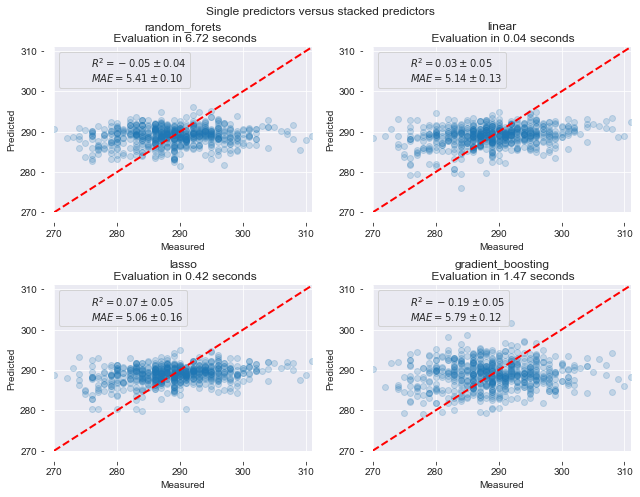

In [202]:
import time
from sklearn.model_selection import cross_validate, cross_val_predict

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [197]:
#Instantiate Regressor and Pipeline
classifier = RandomForestRegressor(criterion='mse', random_state=SEED)
pipe = pipe = Pipeline(steps=[('pca', pca), ('classifier', classifier)])

# Create param grid for GridSearch
param_grid = {
    'pca__n_components' :[2, 3, 4],
    'classifier__n_estimators' : [100, 200],
    'classifier__max_features' : ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [None, 2, 5,10],
    'classifier__min_samples_split' : [2, 10, 20],
    'classifier__min_samples_leaf' : [1, 10, 20]
}

# Instantiate GridSearch
rfr = GridSearchCV(
    pipe,
    param_grid,
    verbose=2,
    n_jobs=-1
)

In [198]:
rfr.fit(X_train, y_train)
y_h_rfr_train = rfr.predict(X_train)
y_h_rfr_test = rfr.predict(X_test)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.7min


KeyboardInterrupt: 

In [ ]:
train_mse = np.sum((y_train - y_h_rfr_train)**2)/df.shape[0]
train_r2 = 1-((np.sum((y_train - y_h_rfr_train)**2))/(np.sum((y_train-np.mean(y_train)**2))))

test_mse = np.sum((y_test - y_h_rfr_test)**2)/df.shape[0]
test_r2 = 1-((np.sum((y_test-y_h_rfr_test)**2))/(np.sum((y_test-np.mean(y_test))**2)))

print(f'Train rMSE: {np.sqrt(train_mse)}')
print(f'Train R2: {train_r2 : 0.0%}')
print(f'Test rMSE: {np.sqrt(test_mse)}')
print(f'Test R2: {test_r2 : 0.0%}')

print('--'*27)
print('Random Forest Regression Best Params:')
print('--'*27)
best_params = rfr_gs.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

In [ ]:
rfr.fit(X, y)

In [ ]:
y_rfr = rfr.predict(X)

mse = np.sum((y - y_rfr)**2)/df.shape[0]
r2 = 1-((np.sum((y - y_rfr)**2))/(np.sum((y-np.mean(y)**2))))
print(f'rMSE: {np.sqrt(mse)}')
print(f'R2: {r2 : 0.2%}')
print('--'*27)
print('Random Forest Regression Best Params:')
print('--'*27)
best_params = rfr_gs.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")